In [1]:
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
from scipy import signal
import scipy.cluster.hierarchy as spc
from pandas import read_excel
from ipywidgets import widgets
from ipywidgets import interactive, HBox, VBox
import plotly.io as pio
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

# Plan

1. Introduction
2. Eco

### Animal care

In [33]:
country_list = ["FR","BE","BG","CY","CZ","DE","DK","EE","ES","FI","AT","GB","GR","HR","HU","IE","IT","LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"]
country_list_iso = ["FRA","BEL","BGR","CYP","CZE","DEU","DNK","EST","ESP","FIN","AUT","GBR","GRC","HRV","HUN","IRL","ITA","LTU","LUX","LVA","MLT","NLD","POL","PRT","ROU","SWE","SVN","SVK"]

In [2]:
#loading data
df_animal_cruelty = pd.read_pickle("./data_vinc/GoogleTrend0.pkl")
df_l214 = pd.read_pickle("./data_vinc/GoogleTrend1.pkl")
df_abattage = pd.read_pickle("./data_vinc/GoogleTrend2.pkl")
df_specism = pd.read_pickle("./data_vinc/GoogleTrend3.pkl")
df_vegan_cook = pd.read_pickle("./data_vinc/GoogleTrend4.pkl")
df_vegetarism = pd.read_pickle("./data_vinc/GoogleTrend5.pkl")
df_veganism = pd.read_pickle("./data_vinc/GoogleTrend6.pkl")
df_meat_substitute = pd.read_pickle("./data_vinc/GoogleTrend7.pkl")

In [5]:
def plot_lines(df,value_smooth, title):
    fig = go.Figure()
    for x in df.columns:
        if value_smooth == 0:
            fig.add_trace(go.Scatter(x=df.index, y=df[x], mode='lines',name=x))
        else:
            fig.add_trace(go.Scatter(x=df.index, y=signal.savgol_filter(df[x],value_smooth, 3), mode='lines',name=x))
    fig.update_layout(title_text=title)
    fig.show()

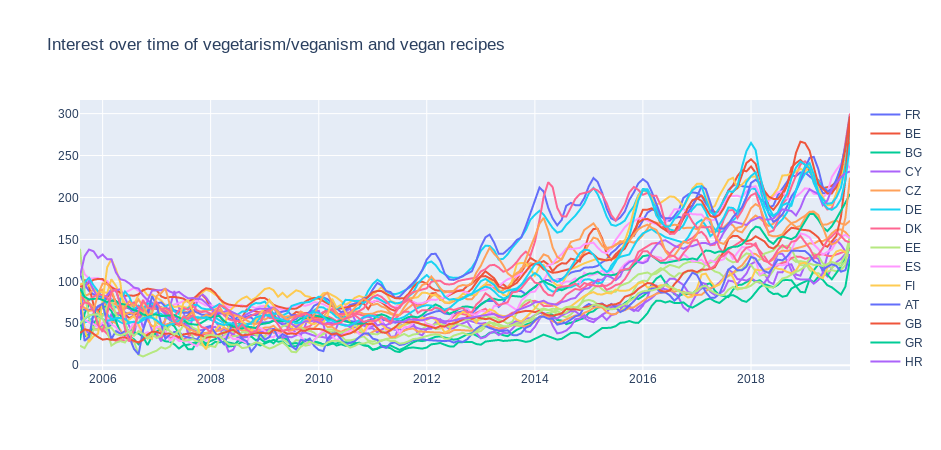

In [39]:
plot_lines((df_veganism+df_vegetarism+df_vegan_cook), 7, "Interest over time of vegetarism/veganism and vegan recipes")

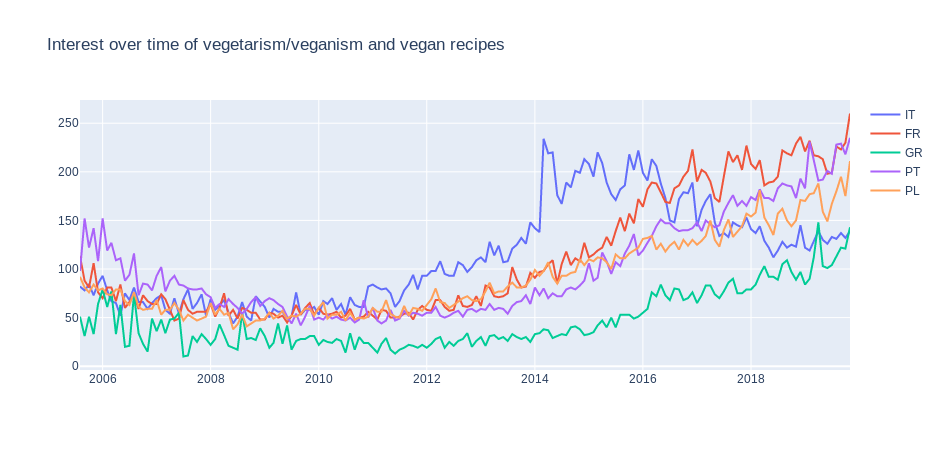

In [24]:
plot_lines((df_veganism+df_vegetarism+df_vegan_cook)[['IT', 'FR', 'GR', 'PT', 'PL']], 0, "Interest over time of vegetarism/veganism and vegan recipes")

As we can see the interest for this topic increased last 10 years, but as we saw before ...

Can we see some similar comportements in those interests? We will now try to regroup countries with similar behavior using k-means algorithm.

In [31]:
#cluster countries based on correlation measure
def getIdx(corr,variableTweak):
    pdist = spc.distance.pdist(corr)
    linkage = spc.linkage(pdist, method='complete')
    idx = spc.fcluster(linkage, variableTweak * pdist.max(), 'distance')
    return idx

def getGroupe(number,idx):
    groupe = []
    for i in range(0,len(idx)):
        x = idx[i]
        if x == number:
            groupe.append(i)
    return groupe

def plotDifferentGroup(idx,dfPlot,indicePlot, title):
    for i in range(1,max(idx)+1):
        df1 = dfPlot[dfPlot.columns[getGroupe(i,idx)]]
        plot_lines(df1,indicePlot, title)

def plotMapStatic(idx, title):
    fig = go.Figure(data=go.Choropleth(
        locations=country_list_iso, # Spatial coordinates
        z = idx, # Data to be color-coded
        locationmode = 'ISO-3', # set of locations match entries in `locations`
        colorscale="Blugrn",
        colorbar_title = "Millions USD",
        showscale = False,
    ))

    fig.update_layout(
        title_text = title,
        geo_scope='europe', # limite map scope to USA
        autosize=False,
        width=800,
        height=800,
        dragmode=False
    )
    fig.show()
    
def plotByGroup(df, title, threshold=0.5, method='hierarchical', n_clusters=3):
    df_corr= df.corr(method='kendall')
    idx = None
    if method== 'hierarchical':
        idx = getIdx(df_corr, threshold)
    else:
        idx=getKMeansGroups(df, n_clusters)+1
    plotDifferentGroup(idx, df, 11, title)
    plotMapStatic(idx, 'Clustering by interest on subject')
    
    
def getKMeansGroups(df, n_clusters=3):
    k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(df.transpose().values)
    return k_means.predict(df.transpose().values)

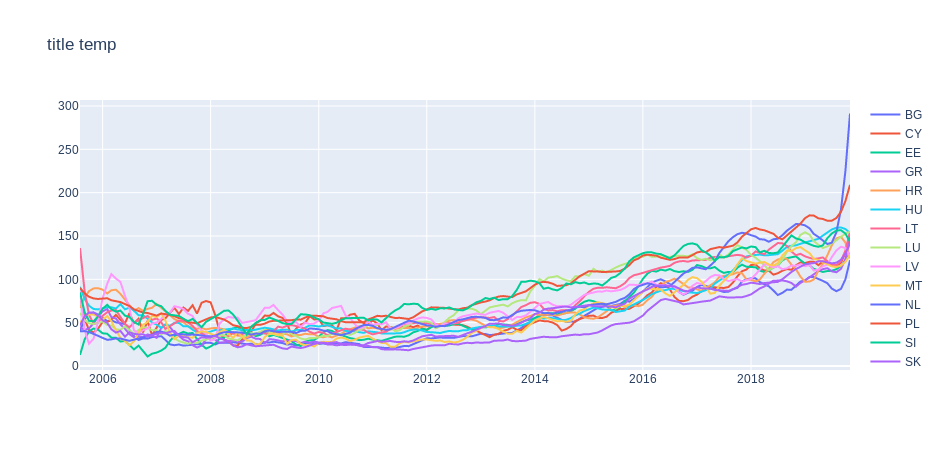

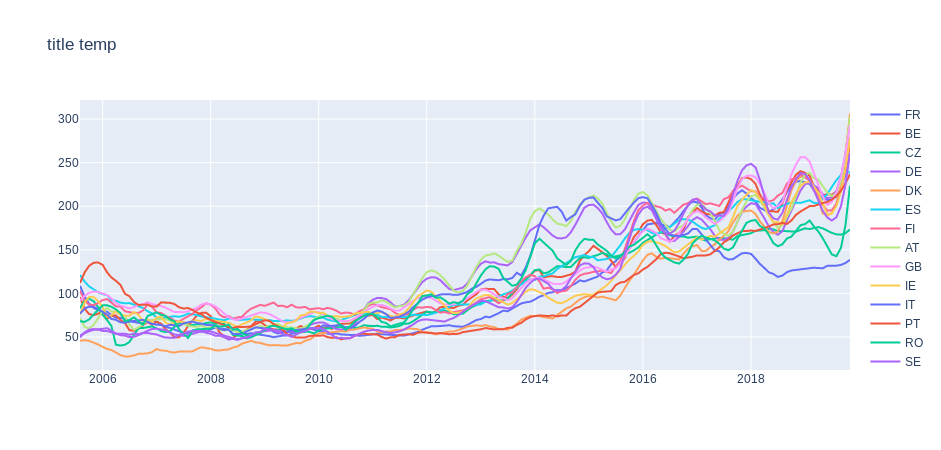

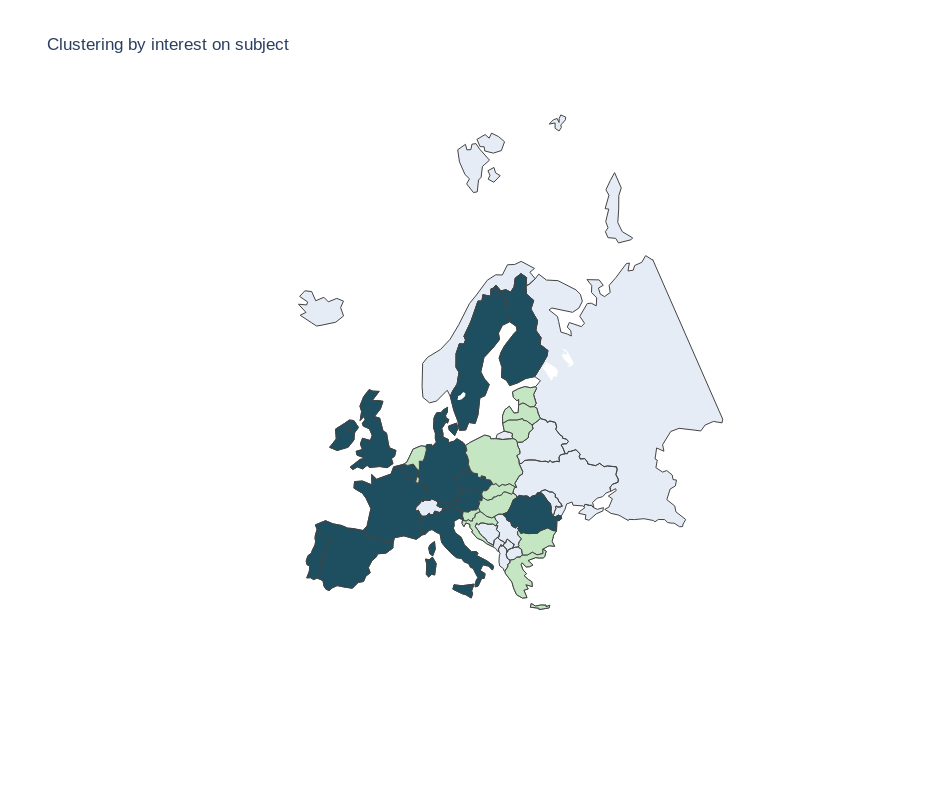

In [34]:
plotByGroup((df_veganism+df_vegetarism+df_vegan_cook), 'title temp', n_clusters=2, method='kmeans')

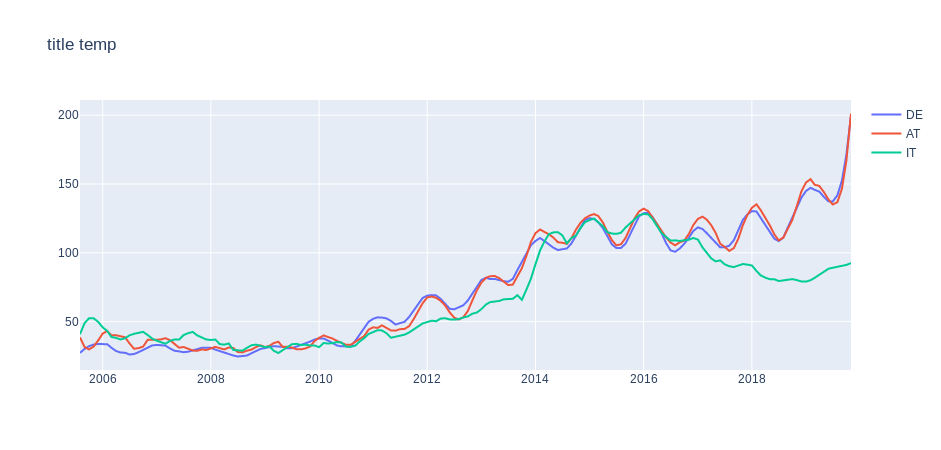

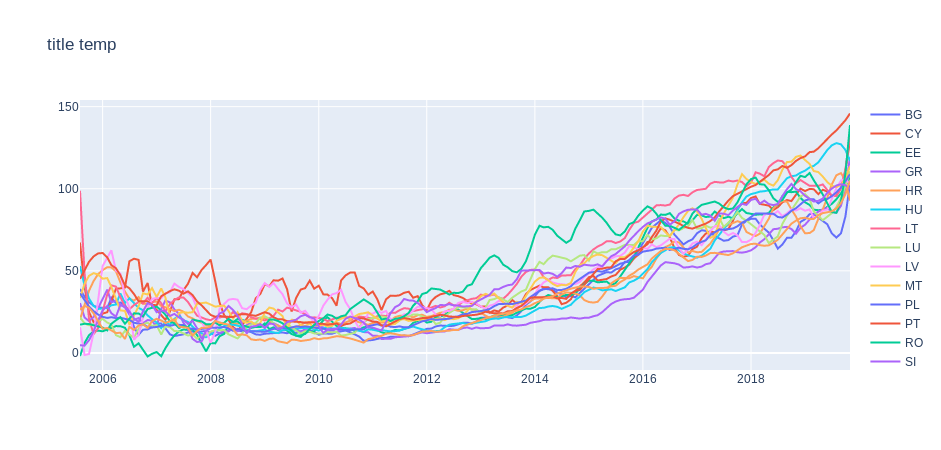

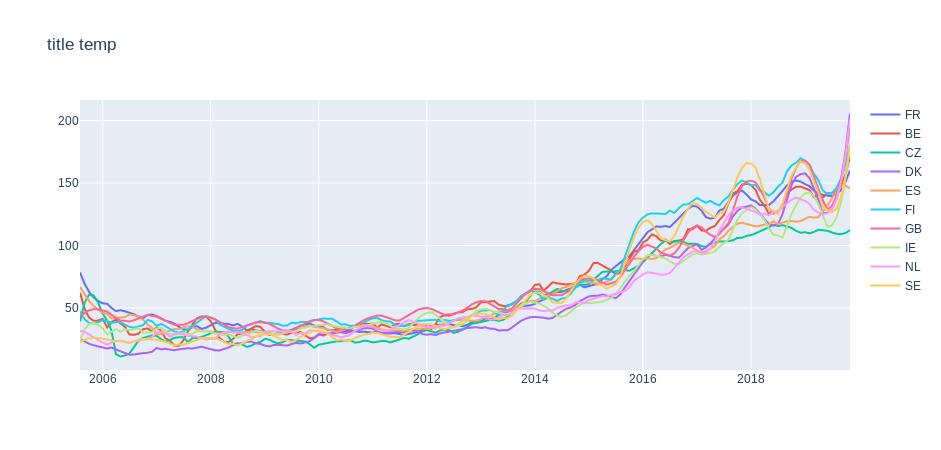

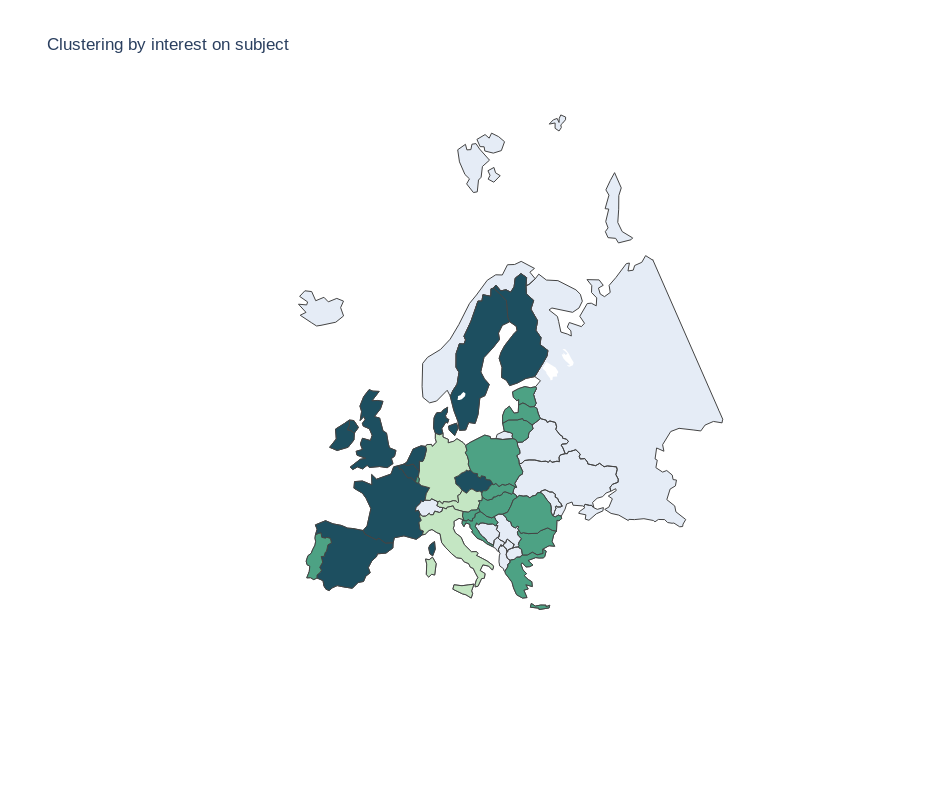

In [40]:
plotByGroup((df_veganism+df_vegan_cook), 'title temp', n_clusters=3, method='kmeans')

As we can see, even if we have high dimensional data, the k-means split we obtained make sense. Even more, when we display the countries that are grouped together, we can see that they are geographicaly close to each other. That might be an avenue worth to explore.